# Multiclass segmentation of sandstone with 3D U-Net 

<p align="center">
        <img src="pexels-pixabay-50570.jpg" width="1000" height="400">
</p>
<p align="center">
My take on @digitalsreenis youtube tutorial to the 3D net
        <a href="https://www.youtube.com/watch?v=Dt73QWZQck4&ab_channel=DigitalSreeni">Link to the Video</a>
</p>

### Imports 

In [15]:
# Setup tensorflow
import tensorflow as tf
# Check tensorflow version
print(tf.__version__)
# Check GPU configuration 
print(tf.test.gpu_device_name())
# import segmentation models
import segmentation_models_3D as sm
# remaining imports 
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

2.9.0
/device:GPU:0


### Load the training images and masks 

In [24]:
# The dataset is taken from youtube channels of @Apeer_micro & @digitalsreeni
# download link:
# https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbWhzd0k3MDRONlgwbDNGSFBwdFVIa0E5ZlVRd3xBQ3Jtc0ttRTFZc2MybGtPOWxGdTljRmFnUEFqLXNqSEpwVktPNUJEek11dDNkT01hTV95dHFhWmtSZGRXUUl3ZmtzSjFOaDJjaHI5dUZta3hfUkRvYjMyXzZmNzZaNkRMQXdjYkNUemtOeTFHRDk5NDJPRzE2SQ&q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU%2Fview%3Fusp%3Dsharing&v=Dt73QWZQck4
from private_path import image_path, mask_path

# Load 256x256x256 pixel image and mask volumes and break it in more managable 64x64x64 patches for training with patchify
image = io.imread(image_path) 
print(f'Image Shape: {image.shape, image.dtype}')
img_patches = patchify(image, (64,64,64), step=64) # step 64 -> no overlap 256/64

mask = io.imread(mask_path)
mask_patches = patchify(mask, (64,64,64), step=64)
# 4 x 64 in every axis for 256 volume 
print(img_patches.shape)

Image Shape: ((256, 256, 256), dtype('uint8'))
(4, 4, 4, 64, 64, 64)


### Get Data ready for input into pretrained model 

In [7]:
# Reshape input_shapes into n_patches, x, y, z
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print('input shape of: (n_patches, x, y, z)')
print(input_img.shape) 

input shape of: (n_patches, x, y, z)
(64, 64, 64, 64)


In [29]:
# Convert gray image to 3 channels(rgb) by stack/copy image 3 times 
train_img = np.stack((input_img,)*3, axis=-1)
# Just add one more dim to masks
train_mask = np.expand_dims(input_mask, axis=4)
print(f'Old Input Input Shape {input_img.shape} converted to {train_img.shape}')
print(f'Old Input Mask Shape {input_mask.shape} converted to {train_mask.shape}')

# One Hot Encode Classes for Classification
num_classes = 4
train_mask_cat = utils.to_categorical(train_mask, num_classes=4)
print('One-Hot-Encoding - Done')
# train-test-split the data
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size=.10, random_state=42) 
print('Train-Test-Split - Done')

Old Input Input Shape (64, 64, 64, 64) converted to (64, 64, 64, 64, 3)
Old Input Mask Shape (64, 64, 64, 64) converted to (64, 64, 64, 64, 1)
One-Hot-Encoding - Done
Train-Test-Split - Done


### Define Model parameters

In [10]:
# pretrained weights that the model dont learn from scratch
encoder_weights = 'imagenet'
# encoder backbone for 3d unet
BACKBONE = 'vgg16'
# softmax for multiclass segmentation - for binary sigmoid 
activation = 'softmax'
patch_size = 64
n_classes = 4
# here 3xGrayscale stack 
channels = 3

LR = 1e-4
optim = tf.keras.optimizers.Adam(LR)

# Define Losses
## dice loss is good because its close to intersection
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
## focal loss is good for imbalanced datasets
focal_loss = sm.losses.CategoricalFocalLoss()
## Combine losses for better acc
total_loss = dice_loss + (1* focal_loss)

# Define Metrics 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

### Preprocess Input Data

In [17]:
# get the preprocessing of the encoder backbone
preprocess_input = sm.get_preprocessing(BACKBONE)
# now preprocess our data in the same way to fit it to the model
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

### Build the Model

In [36]:
model = sm.Unet(BACKBONE, classes=n_classes,
                input_shape=(patch_size, patch_size, patch_size, channels),
                encoder_weights=encoder_weights,
                activation=activation)
model.compile(optimizer= optim, loss=total_loss, metrics=metrics)
print(model.summary())

176606448/176606448 [==============================] - 26s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                          

### Fit the Model

In [ ]:
# Define callback
callback = [ModelCheckpoint('unet.hdf5', monitor= 'iou_score',verbose=1, save_best_only=True)]
# model.fit is run outside of of ipynb because its somehow really slow
history = model.fit(X_train_prep,
                y_train,
                batch_size=8,
                epochs=100,
                verbose=1,
                validation_data=(X_test_prep, y_test))

### Load trained Model

In [13]:
from keras.models import load_model
model = load_model('unet.hdf5', custom_objects={'dice_loss_plus_1focal_loss': total_loss, 
                'iou_score': sm.metrics.iou_score, 
                'f1-score':sm.metrics.f1_score})

### Test on Random Images

1/1 [==============================] - 0s 33ms/step


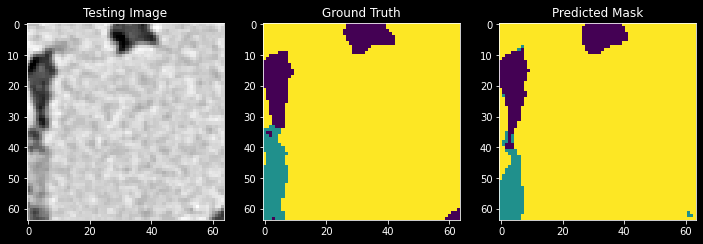

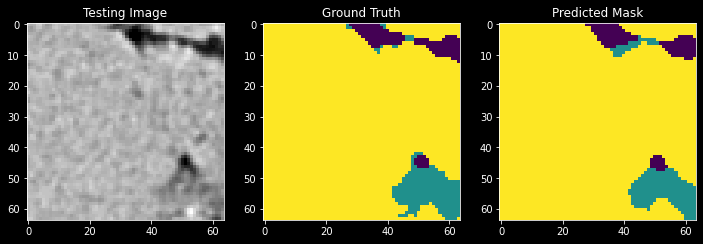

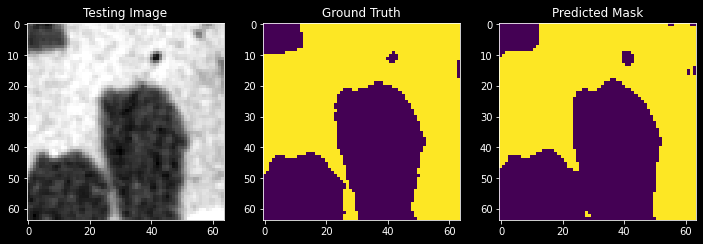

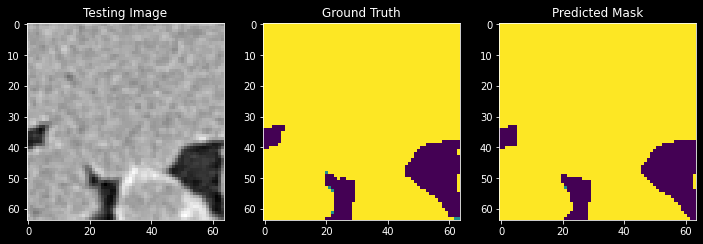

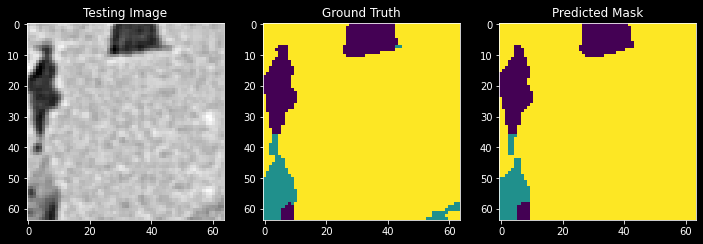

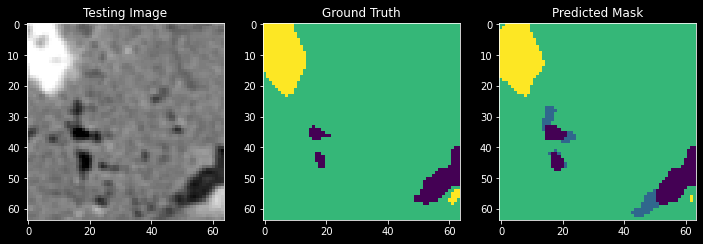

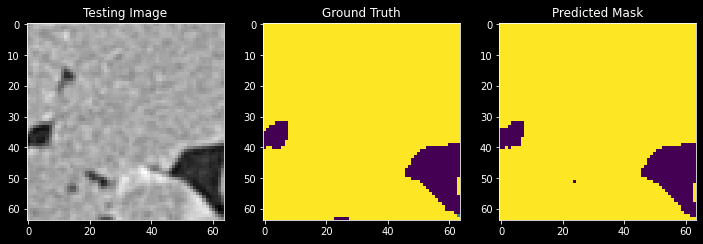

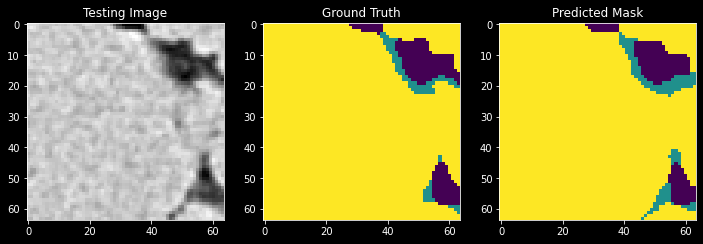

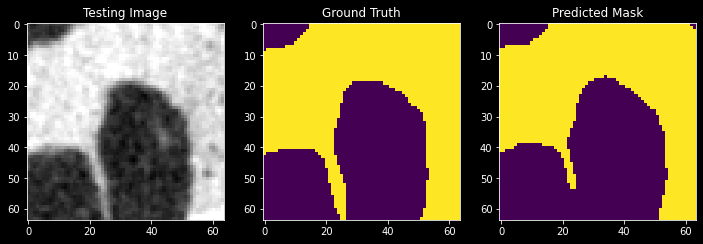

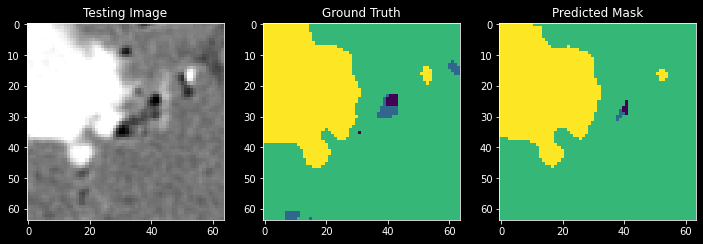

In [22]:
for i in range(10):
        # Chose random Index
        index = np.random.randint(1, len(X_test))
        # load image 
        test_img = X_test[index]
        ground_truth = y_test[index]

        test_img_input = np.expand_dims(test_img, 0)
        test_img_input1 = preprocess_input(test_img_input)

        test_pred1 = model.predict(test_img_input1)
        test_predction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
        # 
        ground_truth_argmax = np.argmax(ground_truth, axis=3)
        # plot prediction 
        slice = i
        plt.figure(figsize=(12,12))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(test_img[slice,:,:,0], cmap='gray')
        plt.subplot(232)
        plt.title('Ground Truth')
        plt.imshow(ground_truth_argmax[slice,:,:])
        plt.subplot(233)
        plt.title('Predicted Mask')
        plt.imshow(test_predction1[slice,:,:])

